# Normalización con lemmatización y contador de palabras

In [1]:
import pandas as pd
import spacy
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import os

# Cargar el modelo de SpaCy con lemmatización y desactivando NER
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# Ajustar número de procesos según los núcleos de la CPU disponibles
n_process = 2

# Leer archivos CSV con Dask
def load_data_with_dask(file_paths):
    df = dd.read_csv(file_paths)
    return df

# Tokenización y lematización por lotes usando Dask para bloques
def lemmatize_abstracts_batch(texts_ddf, batch_size=1000, n_process=n_process):
    lemmas = []
    with ProgressBar():
        for batch in texts_ddf.to_delayed():
            batch_texts = batch.compute()  # Procesar por bloques
            for doc in nlp.pipe(batch_texts, batch_size=batch_size, n_process=n_process):
                lemmas.append([token.lemma_ for token in doc])
    return lemmas

# Función para procesar cada tema sin cargar toda la data a la vez
def process_topic(file_paths, abstract_column='Abstract', batch_size=1000, n_process=n_process):
    df = load_data_with_dask(file_paths)
    texts = df[abstract_column]
    lemmas = lemmatize_abstracts_batch(texts, batch_size=batch_size, n_process=n_process)
    
    # Crear un DataFrame con los lemas
    df_lemmas = pd.DataFrame({'Lemmas': [' '.join(lemma_list) for lemma_list in lemmas]})
    
    return df_lemmas

# Lista de archivos CSV para cada tema (actualiza con tus rutas)
topics = {
    'SustainableFinance': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\SustainableFinance_touse.csv'],
    'CorporateFinance': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\CorporateFinance_touse.csv'],
    'AssetPricingModels': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\AssetPricingModels_touse.csv'],
    'BehavioralFinance' : ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\BehavioralFinance_touse.csv'],
    'FinancialDerivatives': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\FinancialDerivatives_touse.csv'],
    'FinancialEngineering': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\FinancialEngineering_touse.csv'],
    'FinancialRisk': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\FinancialRisk_touse.csv'],
    'PortfolioOptimization': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\PortfolioOptimization_touse.csv']
    # Agrega más temas según corresponda...
}

# Procesar todos los temas y almacenar los lemas en un DataFrame combinado
all_lemmas_df = pd.DataFrame()

for topic, file_paths in topics.items():
    print(f"Procesando tema: {topic}")
    df_lemmas = process_topic(file_paths)
    
    # Agregar los lemas al DataFrame combinado
    all_lemmas_df = pd.concat([all_lemmas_df, df_lemmas], ignore_index=True)

# Guardar los resultados en un archivo CSV
all_lemmas_df.to_csv('lemmatized_abstracts.csv', index=False)


Procesando tema: SustainableFinance
[########################################] | 100% Completed | 206.56 ms
Procesando tema: CorporateFinance
[########################################] | 100% Completed | 203.48 ms
Procesando tema: AssetPricingModels
[########################################] | 100% Completed | 231.25 ms
Procesando tema: BehavioralFinance
[########################################] | 100% Completed | 102.69 ms
Procesando tema: FinancialDerivatives
[########################################] | 100% Completed | 103.42 ms
Procesando tema: FinancialEngineering
[########################################] | 100% Completed | 323.44 ms
Procesando tema: FinancialRisk
[########################################] | 100% Completed | 1.12 ss
[########################################] | 100% Completed | 1.20 ss
Procesando tema: PortfolioOptimization
[########################################] | 100% Completed | 231.55 ms


# Palabras comúnes más repetidas

Archivo 'palabra_frecuencia.csv' generado con éxito.


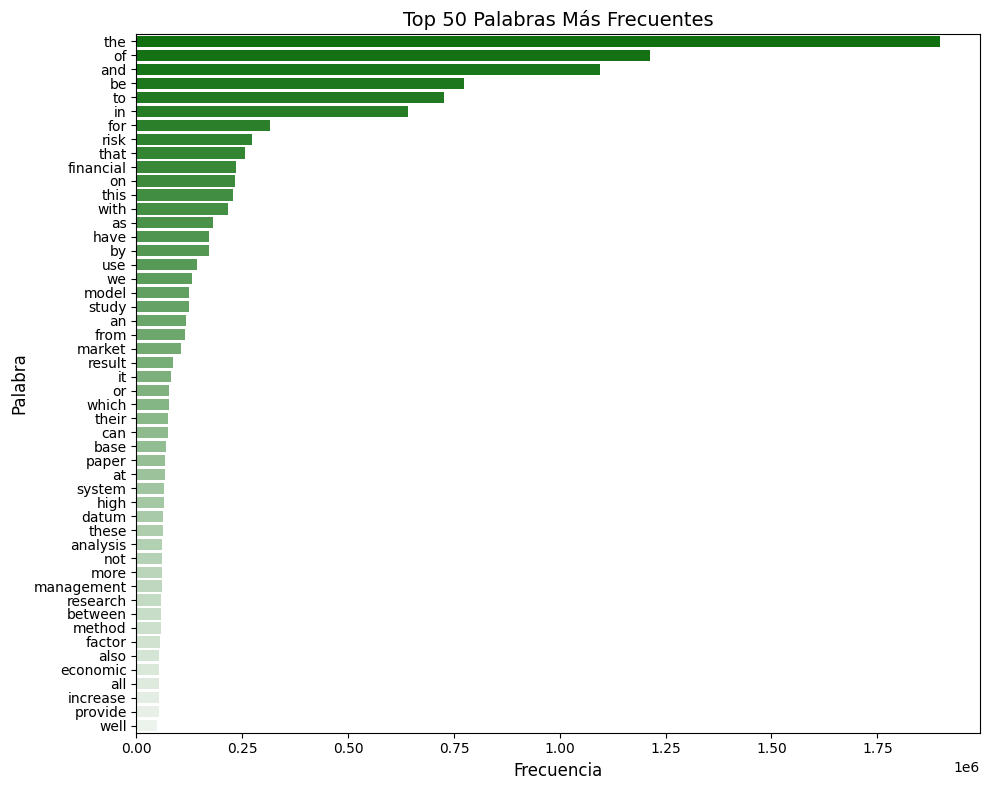

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Clase para analizar la frecuencia de palabras
class WordFrequencyAnalyzer:
    def __init__(self, df):
        # Aceptar un DataFrame en lugar de una ruta de archivo para mayor flexibilidad
        self.df = df
        self.word_freq_df = None
    
    def count_word_frequencies(self):
        # Combinar todas las filas de lemas en una sola lista de documentos
        documents = self.df['Lemmas'].tolist()

        # Inicializar el CountVectorizer para contar la frecuencia de las palabras
        vectorizer = CountVectorizer()

        # Ajustar el vectorizador y transformar el corpus de lemas
        X = vectorizer.fit_transform(documents)

        # Obtener las palabras (vocabulario) y sus frecuencias
        words = vectorizer.get_feature_names_out()
        frequencies = X.sum(axis=0).A1  # A1 para convertir a array unidimensional

        # Crear un DataFrame con las palabras y sus frecuencias
        self.word_freq_df = pd.DataFrame({'Palabra': words, 'Frecuencia': frequencies})

        # Ordenar el DataFrame por la frecuencia en orden descendente
        self.word_freq_df = self.word_freq_df.sort_values(by='Frecuencia', ascending=False)

        # Guardar el DataFrame en un archivo CSV
        self.word_freq_df.to_csv('palabra_frecuencia.csv', index=False)

        print("Archivo 'palabra_frecuencia.csv' generado con éxito.")

    def plot_word_frequencies(self, top_n=50):
        # Seleccionar las top N palabras
        top_words = self.word_freq_df.head(top_n)

        # Crear gráfico de barras con seaborn
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Frecuencia', y='Palabra', data=top_words, palette='light:g_r')

        # Configurar el título y las etiquetas del gráfico
        plt.title(f'Top {top_n} Palabras Más Frecuentes', fontsize=14)
        plt.xlabel('Frecuencia', fontsize=12)
        plt.ylabel('Palabra', fontsize=12)

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()

# Cargar el archivo 'lemmatized_abstracts.csv'
df_lemmas = pd.read_csv('lemmatized_abstracts.csv')

# Crear una instancia de la clase WordFrequencyAnalyzer
analyzer = WordFrequencyAnalyzer(df_lemmas)

# Contar las frecuencias de palabras y generar el archivo CSV
analyzer.count_word_frequencies()

# Graficar las palabras más frecuentes
analyzer.plot_word_frequencies(top_n=50)
